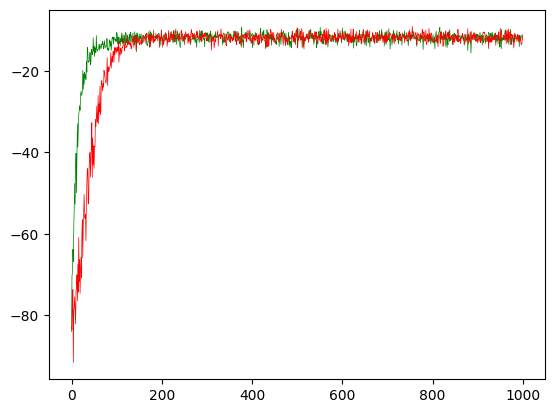

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

class ShortCorridor:
    def __init__(self):
        self.state = 0
        self.remainder_step = 200
    
    def state_shape(self):
        return (3,)
    
    def action_shape(self):
        return 2
     
    def reset(self):
        self.state = 0
        self.remainder_step = 200
        return self.state
    
    def step(self, action):
        if action == 0: #left
            self.state += 1 if self.state == 1 else -1
        else:
            self.state += -1 if self.state == 1 else 1
        if self.state < 0:
            self.state = 0
        self.remainder_step -= 1

        terminated = self.state > 2
        truncated = self.remainder_step < 0
        return terminated, truncated, -1, self.state


def softmax(hs):
    es = np.exp(hs)
    es /= es.sum()
    return es

class ValueFunction:
    def __init__(self, env, alpha):
        self.alpha = alpha
        self.state_shape = env.state_shape()
        self.param = np.zeros(self.state_shape)

    def reset(self):
        self.param = np.zeros(self.state_shape)

    def to_feature(self, state):
        feature = np.zeros(self.state_shape)
        feature[state] = 1
        return feature
    
    def predicate(self, state):
        return np.dot(self.to_feature(state), self.param)
        #return self.param[state]
    
    def train(self, state, delta):
        feature = self.to_feature(state)
        self.param += self.alpha * delta * feature

class Actor:
    def __init__(self, env, alpha):
        self.alpha = alpha
        self.action_shape = env.action_shape()
        self.param = np.zeros(self.action_shape)
        self.param = np.log([19,1])
    
    def reset(self):
        self.param = np.log([19,1])

    def to_feature(self, state, action):
        feature = np.zeros(self.action_shape)
        feature[action] = 1
        return feature
    
    def select_action(self, state):
        probs = softmax(self.param)
        action = np.random.choice(self.action_shape, p = probs)
        return action
        
    def policy(self, state):
        return softmax(self.param)

    def train(self, state, action, delta):
        #eligibility = self.to_feature(state, action) - self.policy(state)
        #self.param += self.alpha * delta * eligibility
        gradient = self.to_feature(state, action)*(1-self.policy(state))
        self.param += self.alpha * delta * gradient


def reinforce_with_baseline(env, actor, value_function, num_episodes, gamma = 1.0):
    reward_stat = np.zeros(num_episodes)
    for episode in range(num_episodes):
        #print("episode ",episode)
        state = env.reset()
        records = []
        total_reward = 0
        while True:
            action = actor.select_action(state)  
            terminated, truncated, reward, next_state = env.step(action)
            total_reward += reward
            records.append((state, action, reward))
            if terminated or truncated:
                break
            state = next_state
        g = 0
        for t in range(len(records)-1, -1, -1):
            state, action, reward = records[t]
            g = g * gamma + reward
            v_hat = value_function.predicate(state)
            delta = g - v_hat
            #print("delta ", delta, "g ", g, "v_hat ", v_hat)
            value_function.train(state, delta)
            actor.train(state, action, delta * math.pow(gamma, t))
        reward_stat[episode] = total_reward
    return reward_stat

def actor_critic(env, actor, critic, num_episodes, gamma = 1.0):
    reward_stat = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        gamma_power = 1
        while True:
            action = actor.select_action(state)
            terminated, truncated, reward, next_state = env.step(action)
            total_reward += reward
            vs_prime = 0 if terminated else critic.predicate(next_state)
            delta = reward + vs_prime - critic.predicate(state)
            critic.train(state, delta)
            actor.train(state, action, delta * gamma_power)
            if terminated or truncated:
                break
            gamma_power *= gamma
            state = next_state
        reward_stat[episode] = total_reward
    return reward_stat

env = ShortCorridor()

num_episodes = 1000
num_run = 100

avg_reward = np.zeros(num_episodes)
for n in range(num_run):
    value_function = ValueFunction(env, math.pow(2,-6))
    actor = Actor(env, math.pow(2,-9))
    reward_stat = reinforce_with_baseline(env, actor, value_function, num_episodes)
    avg_reward += reward_stat
avg_reward /= num_run
plt.plot(range(len(avg_reward)),avg_reward,"g",linewidth=0.5)

avg_reward = np.zeros(num_episodes)
for n in range(num_run):
    value_function = ValueFunction(env, math.pow(2,-6))
    actor = Actor(env, math.pow(2,-9))
    reward_stat = actor_critic(env, actor, value_function, num_episodes)
    avg_reward += reward_stat
avg_reward /= num_run
plt.plot(range(len(avg_reward)),avg_reward,"r",linewidth=0.5)

